In [1]:
import sys, platform, os
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import pickle

import emcee
from multiprocess import Pool
from getdist import plots, MCSamples

In [2]:
# %matplotlib notebook

In [3]:
## binning

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx   #,array[idx]


def compute_bins(lmin, lmax, Nbins, binning_type='no_binning'):

    if binning_type == 'no_binning':
        
        return None
    
    elif binning_type == 'by_number_modes':

        num_modes = np.zeros(lmax+1)
        cumulative_num_modes = np.zeros(lmax+1)

        bin_edges = np.zeros(Nbins+1)
        bin_edges[0] = lmin

        cumulative = 0

        for i in range(lmin,lmax+1):

            num_modes[i] = 2*i +1 #num_modes per l

            cumulative += num_modes[i]
            cumulative_num_modes[i] = cumulative

        for i in range(1,Nbins+1):

            #Numero_de_modos_por_bin*i #cumulative modes up to bin "i"

            bin_edges[i] = find_nearest(cumulative_num_modes, num_modes.sum() / Nbins * i)#Numero_de_modos_por_bin*i)

        Num_modes_total = num_modes.sum()
        print(f'Total number of modes in (l_min = {lmin}, l_max = {lmax}) = {Num_modes_total}')

        Num_modes_per_bin = Num_modes_total / Nbins
        print("Number of modes in each bin = ", Num_modes_per_bin)

        bin_edges = np.asarray(bin_edges,int)

        return Num_modes_per_bin, bin_edges #, cumulative_num_modes

    elif binning_type == 'equally_spaced':

        bin_edges = np.zeros(Nbins+1)
        bin_width = ( lmax - lmin ) / Nbins
        
        for i in range(Nbins+1):
            bin_edges[i] = lmin + i * bin_width
            
        bin_edges = np.asarray(bin_edges,int)
        
        Num_modes_per_bin = np.zeros(Nbins)
        
        for i in range(Nbins):
            
            for j in range(bin_edges[i],bin_edges[i+1]):
                
                Num_modes_per_bin[i] += 2 * j + 1 

        return Num_modes_per_bin, bin_edges #, cumulative_num_modes
        
def binning_dls(dls, lmin, lmax, Nbins, binning_type='no_binning', ell=None, clmean=False):
    
    if binning_type == 'no_binning':
        
        if ell.all == None:
            
            ell_binned = np.arange(lmin,lmax+1)
        
        else:
            
            ell_binned = ell
        
        dls_binned = dls
        
        deltaell_binned = np.ones( len( dls ) )
        
        return ell_binned, dls_binned, deltaell_binned, bin_edges
    
    else:
        
        Numero_de_modos_por_bin, bin_edges = compute_bins(lmin,lmax,Nbins,binning_type=binning_type) 

        if ell.all == None:
            ell_to_bin = np.arange(lmin,lmax+1)
        else:
            ell_to_bin = ell

        dls_to_bin = dls

        ell_binned_weigthed_sum = np.zeros(Nbins)
        dls_binned_sum = np.zeros(Nbins)
        count_bin = np.zeros(Nbins)
        
        bin_indices = np.digitize(ell_to_bin,bin_edges)

        for i in range( Nbins ):
            mask = ( bin_indices == i+1 )
            count_bin[i] = np.sum( mask )
            dls_binned_sum[i] = np.sum( dls_to_bin[mask] )
            ell_binned_weigthed_sum[i] = np.sum( ell_to_bin[mask] * dls_to_bin[mask])
#             if i==0:
#                 print('i=0')
#                 print(mask)
#                 print(count_bin)
#                 print(dls_binned_sum)
#                 print(ell_binned_weigthed_sum)
#             mask = (ell_to_bin >= bin_edges[i]) * (ell_to_bin < bin_edges[i+1])
#             weight = dls_to_bin[mask]/np.sum(dls_to_bin[mask])
#             ell_binned[i] = np.sum(weight*ell_to_bin[mask]) # it doesn't work well if cls_to_bin is extremely sharp
#             dls_binned[i] = np.sum(dls_to_bin[mask])/np.sum(mask)
        
        ell_binned = ( ell_binned_weigthed_sum / dls_binned_sum ).astype(int)
        
        if clmean:
            
            dls_binned = dls_binned_sum / count_bin
            
        else:
            
            dls_binned = np.zeros(len(ell_binned))
            
            for i in range(len(ell_binned)):
                
                dls_binned[i] = dls_to_bin[ell_binned[i]-lmin]
            
        deltaell_binned = bin_edges[1:] - bin_edges[:-1]
        
        return ell_binned, dls_binned, deltaell_binned, bin_edges

def give_dl_bb(r=0, Alens=1.):
    if lensing == 'yes':        
        power_spectrum = None
        power_spectrum *= Alens
        power_spectrum += r * fit_model
        return power_spectrum
    elif lensing == 'no':
        power_spectrum = r * fit_model
        return power_spectrum
    else:
        raise Exception('Choose lensing yes or no')
        return None

def log_prior(x):
    
    if lensing == 'yes':

        r, Alens = x

        if r > 1 or r < -1:
            return -np.inf
    
        if Alens < 0.1 or Alens > 4:
            return -np.inf

    elif lensing == 'no':

        r = x

        if r > 1 or r < -1:
            return -np.inf
    
    else:
        
        raise Exception('Choose lensing yes or no')
        
    return 0

def like(x):
    
    if lensing == 'yes':
        
        r, Alens = x

        ymodel = np.array([give_dl_bb(r, Alens)])
        yobs = observation
        res = ymodel - yobs

        lp = log_prior(x)

        L_cc2 = - 0.5 * ((res[0] @ cov_inv @ res[0].T))

        L = lp + L_cc2

        return L
    
    elif lensing == 'no':
        
        r = x

        ymodel = np.array([give_dl_bb(r, Alens=0)])
        yobs = observation
        res = ymodel - yobs

        lp = log_prior(x)

        L_cc2 = - 0.5 * ((res[0] @ cov_inv @ res[0].T))

        L = lp + L_cc2

        return L    

In [4]:
base_dir = '/home/nahue-ofi/'
# base_dir = '/home/nahue/'

lmin = 10
lmax = 600
Nbins= 100 # set to 0 for no binning
Tcmb = 2.7255*1e6 #muK
lensing = 'no'
sim_type = 'std_nogws'
gw_source = True
clmean= False
binning_type = 'by_number_modes' # 'no_binning' # 'equally_spaced' #
noise_level_obs = 1
nwalkers = 30
mcmc_iterations = 300
n_runs = 50
r = [0.03, 0.02, 0.01, 0.008, 0.005, 0.003, 0.001]
sim_type_list = ['std_std', 'int_std', 'int_int','std_nogws']

ell_base = np.load( base_dir+'CMM-Pipeline/scripts_nahuel/Dls/ell.npy' )[lmin:lmax+1]
        
dl_nogws_nolensing = np.load(base_dir+'CMM-Pipeline/scripts_nahuel/Dls/dl_fiducial_r1_nogw_nolensing.npy')[lmin:lmax+1]
dl_std_nolensing = np.load(base_dir+'CMM-Pipeline/scripts_nahuel/Dls/dl_fiducial_r1_std_nolensing.npy')[lmin:lmax+1]
dl_int_nolensing = np.load(base_dir+'CMM-Pipeline/scripts_nahuel/Dls/dl_fiducial_r1_std_nint_nolensing.npy')[lmin:lmax+1]

thetabeam_deg = 0.1
thetabeam = thetabeam_deg*np.pi/180
thetapixel = thetabeam
sensitivity = 200 #muK sqrt(s)
observing_time_per_pixel = 1*85 #s
sigmapixel = sensitivity/np.sqrt(observing_time_per_pixel)
npix = 4*np.pi/thetabeam**2

w = (4*np.pi*sigmapixel/npix)**(-1)

discard_mc = 80
thin_mc = 15

In [5]:
for r_data in r:
    
    r_data_string = str(r_data).split('.')[-1]
    
    ## "observed" data
    
    if lensing == 'yes':
        
        if sim_type == 'std_std':
            data = r_data*dl_std_withlensing
            fit_model = dl_std_withlensing
        
        elif sim_type == 'int_int':
            data = r_data*dl_int_withlensing
            fit_model = dl_int_withlensing
        
        elif sim_type == 'int_std':
            data = r_data*dl_int_withlensing
            fit_model = dl_std_withlensing
        
        elif sim_type == 'std_nogws':
            data = r_data*dl_std_withlensing
            fit_model = dl_nogws_withlensing
    
    elif lensing == 'no':
        
        if sim_type == 'std_std':
            data = r_data*dl_std_nolensing
            fit_model = dl_std_nolensing
        
        elif sim_type == 'int_int':
            data = r_data*dl_int_nolensing
            fit_model = dl_int_nolensing
        
        elif sim_type == 'int_std':
            data = r_data*dl_int_nolensing
            fit_model = dl_std_nolensing
        
        elif sim_type == 'std_nogws':
            data = r_data*dl_std_nolensing
            fit_model = dl_nogws_nolensing
            
            
    ell_binned, dls_binned, deltaell_binned, bin_edges = binning_dls(ell=ell_base,dls=data,lmin=lmin,lmax=lmax,Nbins=Nbins,clmean=clmean,binning_type=binning_type)
    
    # print(deltaell_binned)
    # print(len(deltaell_binned))
    # print(len(ell_binned))
    
    # plt.figure()
    
    # plt.suptitle('Spectra for different CMB seeds')
    
    # plt.plot( ell_base, data, '.', label='data' ,alpha=0.5)
    # plt.plot( ell_binned, dls_binned, 'x', label='binned data' )
    # plt.plot( ell_binned, give_dl_bb(r=r_data,Alens=0.), label='fit_model true r')
    # # for i in range(len(bin_edges)):
    # #     plt.axvline(bin_edges[i])
    
    # plt.yscale('log')
    # plt.xscale('log')
    # plt.grid()
    # plt.legend()
    # plt.tight_layout
    
    variance = 2 / ( 2 * ell_binned + 1 ) / deltaell_binned * ( dls_binned + np.exp(( ell_binned * thetabeam )**2 ) / w )**2
    
    cov_cc_diag = np.zeros( ( len( ell_binned ), len( ell_binned ) ) )
    np.fill_diagonal( cov_cc_diag, variance )
    cov = cov_cc_diag
    cov_inv = np.linalg.inv( cov )
    
    if lensing == 'yes':
        
        nparams = 2
        
        x0 = np.zeros((nwalkers, nparams))
        x0[:, 0] = np.random.normal(r_data*(1.3), r_data/3, (nwalkers))
        x0[:, 1] = np.random.normal(1, 0.01, (nwalkers))
        
        r_mean = np.zeros(n_runs)
        r_std = np.zeros(n_runs)
        Alens_std = np.zeros(n_runs)
        Alens_std = np.zeros(n_runs)
        
    elif lensing == 'no':
        
        nparams = 1
        x0 = np.zeros((nwalkers, nparams))
        x0[:, 0] = np.random.normal(r_data*(1.3), r_data/3, (nwalkers))
    
        r_mean = np.zeros(n_runs)
        r_std = np.zeros(n_runs)
        
    fit_model = np.interp(ell_binned, ell_base, fit_model)
    
    for i in range(n_runs):
    
        observation = dls_binned + noise_level_obs * np.random.multivariate_normal(np.zeros(len(dls_binned)),cov)  
    
        with Pool() as pool:
            sampler = emcee.EnsembleSampler(nwalkers, nparams, like, pool=pool)
            sampler.run_mcmc(x0, mcmc_iterations)
    
        chains = sampler.get_chain()
        
        chainflat = sampler.get_chain(discard=discard_mc, thin=thin_mc, flat=True)
        
        s = MCSamples(samples=chainflat)
        
        if i == 0:
            
            for j in range(nparams):
    
                plt.figure()
    
                for k in range(nwalkers):
                    plt.plot(chains[:, k, j], '-k', alpha=0.05)
                plt.plot(np.mean(chains, axis=1)[:, j], '-r')
                plt.plot(np.std(chains, axis=1)[:, j], '-b')
                plt.grid()
                plt.tight_layout
                plt.savefig(f'chains_1realization_{sim_type}_{r_data_string}')
                plt.close()
    
    
            # Triangle plot
            g = plots.get_subplot_plotter(width_inch=8)
            g.triangle_plot([s], filled=True, title_limit=1)
            plt.savefig(f'r_posterior_1realization_{sim_type}_r{r_data_string}')
            plt.close()
            
            plt.figure()
            
            plt.plot(ell_binned,observation,'.',label='observation')
            plt.plot(ell_binned,dls_binned,label='true spectrum')
            plt.xscale('log')
            plt.yscale('log')
    
            plt.grid()
            plt.legend()
            plt.savefig(f'observation_true_spectrum_{sim_type}_r{r_data_string}')
            plt.close()
    
        if lensing == 'yes':
            r_mean[i] = np.mean(s[0])
            r_std[i] = np.std(s[0])
            Alens_mean[i] = np.mean(s[1])
            Alens_std[i] = np.std(s[1])
        elif lensing == 'no':
            r_mean[i] = np.mean(s[0])
            r_std[i] = np.std(s[0])
        
    np.save(f'r_mean_{sim_type}_r{r_data_string}',r_mean)
    np.save(f'r_std_{sim_type}_r{r_data_string}',r_std)

Total number of modes in (l_min = 10, l_max = 600) = 361101.0
Number of modes in each bin =  3611.01
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Remove

In [6]:
results = {}
for sim_type in sim_type_list:
    for rr in r:
        rr = str(rr).split('.')[-1]
        try:
            r_mean = np.load(f'r_mean_{sim_type}_r{rr}.npy')
            r_std = np.load(f'r_std_{sim_type}_r{rr}.npy')
            results[f'r_mean_{sim_type}_r{rr}'] = r_mean
            results[f'r_std_{sim_type}_r{rr}'] = r_std
        except:
            pass

print(results.keys())

dict_keys(['r_mean_std_std_r03', 'r_std_std_std_r03', 'r_mean_std_std_r02', 'r_std_std_std_r02', 'r_mean_std_std_r01', 'r_std_std_std_r01', 'r_mean_std_std_r008', 'r_std_std_std_r008', 'r_mean_std_std_r005', 'r_std_std_std_r005', 'r_mean_std_std_r003', 'r_std_std_std_r003', 'r_mean_std_std_r001', 'r_std_std_std_r001', 'r_mean_int_std_r03', 'r_std_int_std_r03', 'r_mean_int_std_r02', 'r_std_int_std_r02', 'r_mean_int_std_r01', 'r_std_int_std_r01', 'r_mean_int_std_r008', 'r_std_int_std_r008', 'r_mean_int_std_r005', 'r_std_int_std_r005', 'r_mean_int_std_r003', 'r_std_int_std_r003', 'r_mean_int_std_r001', 'r_std_int_std_r001', 'r_mean_int_int_r03', 'r_std_int_int_r03', 'r_mean_int_int_r02', 'r_std_int_int_r02', 'r_mean_int_int_r01', 'r_std_int_int_r01', 'r_mean_int_int_r008', 'r_std_int_int_r008', 'r_mean_int_int_r005', 'r_std_int_int_r005', 'r_mean_int_int_r003', 'r_std_int_int_r003', 'r_mean_int_int_r001', 'r_std_int_int_r001', 'r_mean_std_nogws_r03', 'r_std_std_nogws_r03', 'r_mean_std_nog

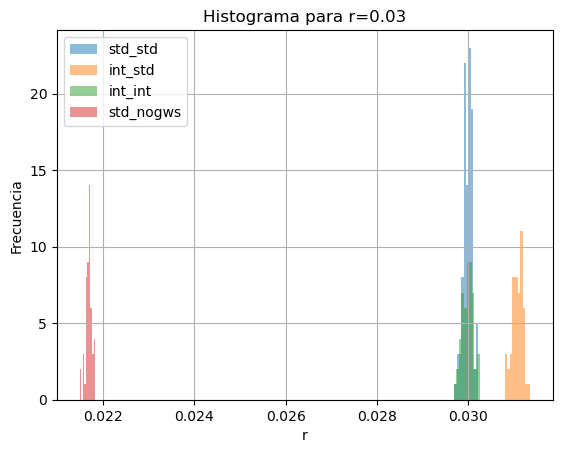

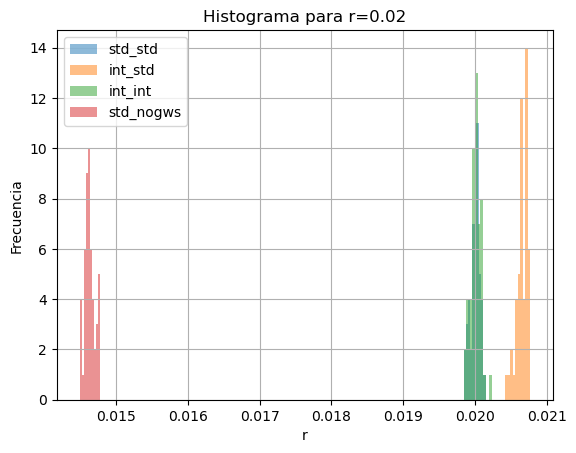

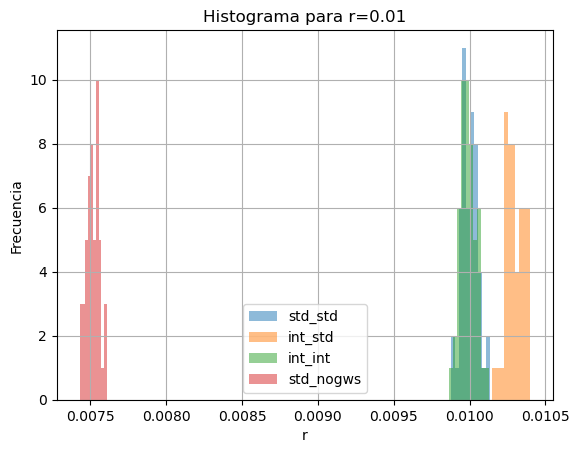

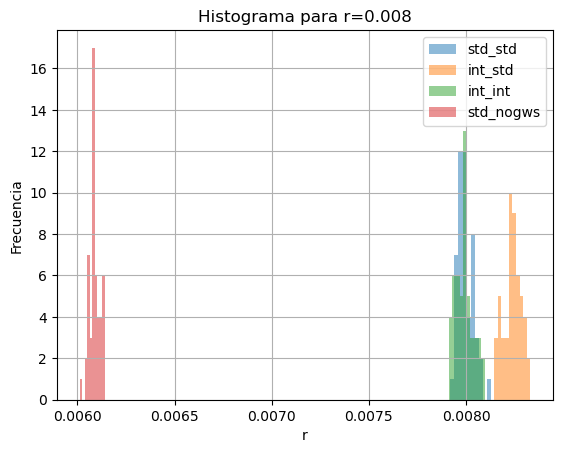

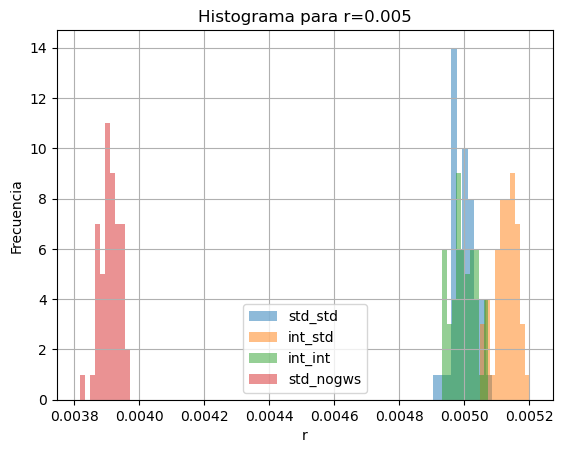

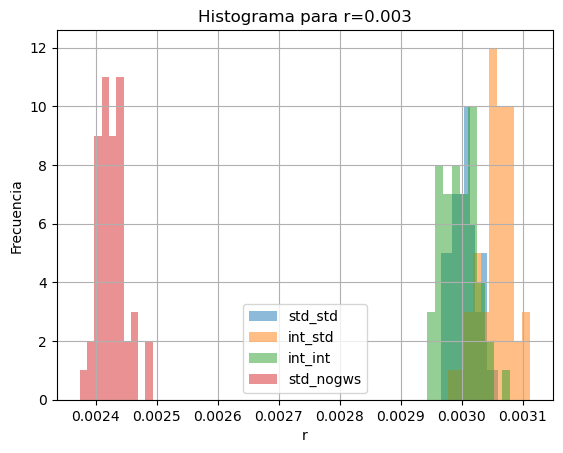

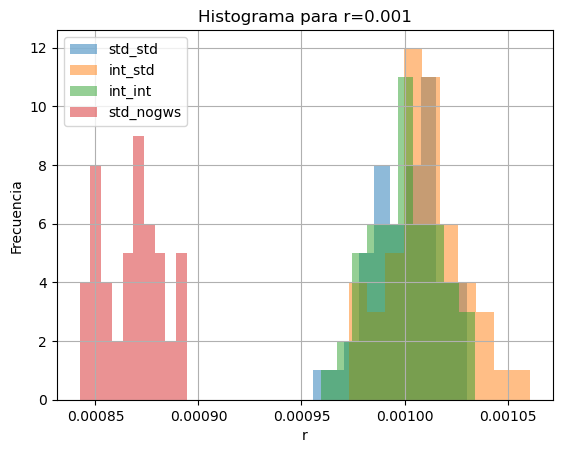

In [7]:
for rr in r:
    rr = str(rr).split('.')[-1]       
    fig, ax = plt.subplots()
    ax.set_title(f'Histograma para r=0.{rr}')
    ax.set_xlabel('r')
    ax.set_ylabel('Frecuencia')
    plt.grid()
    for sim_type in sim_type_list:
        try:
            ax.hist(results[f'r_mean_{sim_type}_r{rr}'], bins=10, alpha=0.5, label=f'{sim_type}')
            ax.legend()#loc='upper right')
        except:
            pass

In [11]:
r_std_std_mean = np.zeros(len(r))
r_int_std_mean = np.zeros(len(r))
r_int_int_mean = np.zeros(len(r))
r_std_nogws_mean = np.zeros(len(r))
r_std_max_per_realization = np.zeros(len(r))
r_std_mean_per_realization = np.zeros(len(r))
r_std_of_the_r_mean_distribution = np.zeros(len(r))

for i,rr in enumerate(r):
    r_name = str(rr).split('.')[-1]
    r_std_std_mean[i] = np.mean(results[f'r_mean_std_std_r{r_name}'])
    r_int_std_mean[i] = np.mean(results[f'r_mean_int_std_r{r_name}'])
    r_int_int_mean[i] = np.mean(results[f'r_mean_int_int_r{r_name}'])
    r_std_nogws_mean[i] = np.mean(results[f'r_mean_std_nogws_r{r_name}'])
    r_std_max_per_realization[i] = np.max(np.concatenate((results[f'r_std_int_std_r{r_name}'],results[f'r_std_std_std_r{r_name}'])))
    r_std_mean_per_realization[i] = np.mean(np.concatenate((results[f'r_std_int_std_r{r_name}'],results[f'r_std_std_std_r{r_name}'])))
    r_std_of_the_r_mean_distribution[i] = ( np.std(results[f'r_mean_int_std_r{r_name}']) + np.std(results[f'r_mean_int_std_r{r_name}']) ) / 2

biasr = r_int_std_mean - r_std_std_mean
biasr_nogws = r_std_nogws_mean - r_std_std_mean
consistencyr = r_int_int_mean - r_std_std_mean

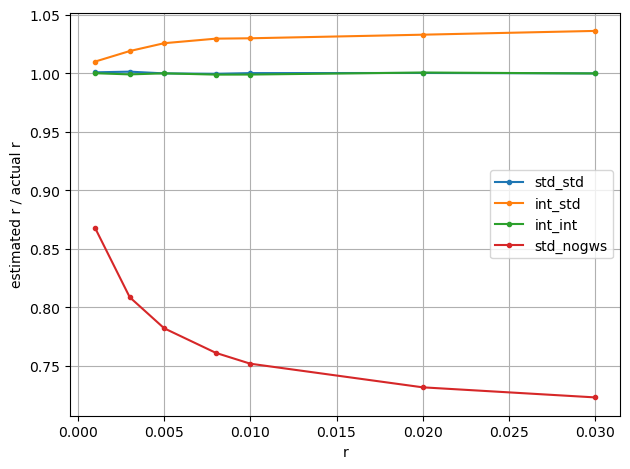

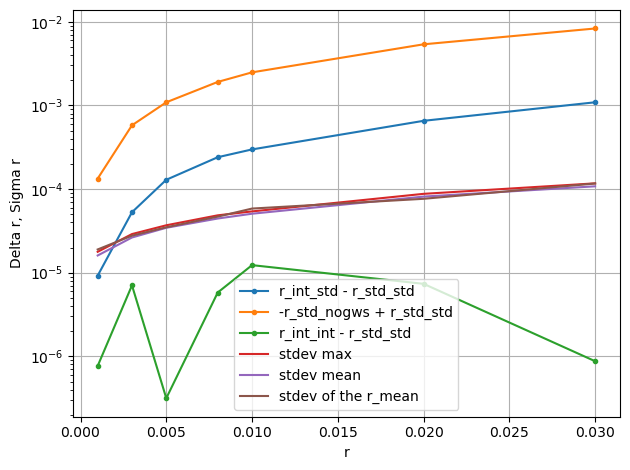

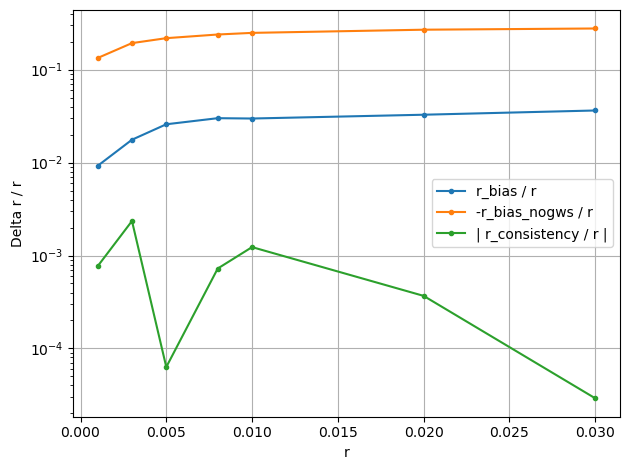

In [14]:
plt.figure()
plt.plot(r,r_std_std_mean/r,'.-',label='std_std')
plt.plot(r,r_int_std_mean/r,'.-',label='int_std')
plt.plot(r,r_int_int_mean/r,'.-',label='int_int')
plt.plot(r,r_std_nogws_mean/r,'.-',label='std_nogws')
plt.xlabel('r')
plt.ylabel('estimated r / actual r')
# plt.yscale('log')
plt.legend()
plt.grid()
plt.tight_layout()

plt.figure()
plt.plot(r,biasr,'.-',label='r_int_std - r_std_std')
plt.plot(r,-biasr_nogws,'.-',label='-r_std_nogws + r_std_std')
plt.plot(r,np.abs(consistencyr),'.-',label='r_int_int - r_std_std')
plt.plot(r,r_std_max_per_realization, label='stdev max')
plt.plot(r,r_std_mean_per_realization, label='stdev mean')
plt.plot(r,r_std_of_the_r_mean_distribution, label='stdev of the r_mean')
plt.yscale('log')
plt.xlabel('r')
plt.ylabel('Delta r, Sigma r')
plt.legend()
plt.grid()
plt.tight_layout()

plt.figure()
plt.plot(r,biasr/r,'.-',label='r_bias / r')
plt.plot(r,-biasr_nogws/r,'.-',label='-r_bias_nogws / r')
plt.plot(r,np.abs(consistencyr)/r,'.-',label='| r_consistency / r |')
plt.yscale('log')
plt.xlabel('r')
plt.ylabel('Delta r / r')
plt.legend()
plt.grid()
plt.tight_layout()